In [1]:
#######################################################################
#
# Contains a config and dataset for running, testing, and training
# on NOvA data contained in hdf5 files.
#
# Also included are examples for viewing data, testing a model, and
# training.
#
#######################################################################


import h5py
import numpy as np
import torch
def to_categorical(y, num_classes=None, dtype="float32"):
    y = np.array(y, dtype="int")
    input_shape = y.shape

    # Shrink the last dimension if the shape is (..., 1).
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.reshape(-1)
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical


#from .utils import *


# A class for loading nova images from numpy arrays in an hdf5 file
class novaDataset():
    def __init__(self, files):
        self._image_ids = []
        self.image_info = []
        self.load_nova(files)
        
    # Load the nova classes, and set the the image ids
    def load_nova(self, filelist):
        n = 0  # keep tracking of the total number of events
        
        for f in filelist:
            h5 = h5py.File(f, 'r')
            labs = h5['label'][:]
            Es = h5['energy'][:]
            object_arrays = h5['cvnobjmap'][:]
            

            for i, (lab, E,object_array) in enumerate(zip(labs, Es,object_arrays)):
                if lab == 15:  # omit cosmics
                    continue
                if E > 10:  # omit real crazy events
                    continue
                if np.max(object_array)>5:
                    continue
                # use both x and y views together
                self.add_image('NOvA', n, f, idx=i, view='X')
                n += 1
                self.add_image('NOvA', n, f, idx=i, view='Y')
                n += 1
            h5.close()

        print('Loaded', n, 'images.')


    # Transform the 1D pixelmap array to one of the views
    def transform_pm(self, pm, view):
        # if pixel map geometry changes so will this
        newpm = pm.reshape(2, 100, 80)
        if view == 'X':
            return newpm[0]
        else:
            return newpm[1]
    def add_image(self, source, image_id, path, **kwargs):
        image_info = {
            "id": image_id,
            "source": source,
            "path": path,
        }
        image_info.update(kwargs)
        self.image_info.append(image_info)
    
    # Useful for visualizing results
    def load_image_BonW(self, image_id):
        info = self.image_info[image_id]
        hf = h5py.File(info['path'], 'r')
        pm = hf['cvnmap'][info['idx']]
        pm = self.transform_pm(pm, info['view'])
        hf.close()

        image = np.zeros(pm.shape + (3,))

        image[pm > 0] = [255, 255, 255]

        return image

    # Pixel map of the hits
    def load_image(self, image_id):
        info = self.image_info[image_id]
        hf = h5py.File(info['path'], 'r')
        pm = hf['cvnmap'][info['idx']]

        pm = self.transform_pm(pm, info['view'])
        hf.close()

        # second channel is boolean for hit or no hit
        blue = np.zeros_like(pm)
        blue[pm > 0] = 255

        image = np.zeros(pm.shape + (3,))
        image[:, :, 0] = pm
        image[:, :, 1] = blue
        image[:, :, 2] = blue

        return self.pm_resize(image)

    # Turn each cell into 9 (3x3) and remove the last 15 planes.
    # Keeps input size under 256x256
    def pm_resize(self, image, n=3):
        return image[:-15, :].repeat(n, axis=0).repeat(n, axis=1)
        #return image[:, :].repeat(n, axis=0).repeat(n, axis=1)

    # Create the binary mask from the label and object instance of each pixel
    def load_mask(self,image_id):
        info = self.image_info[image_id]
        hf = h5py.File(info['path'],'r')
        object_array = hf['cvnobjmap'][info['idx']]
        object_array = self.transform_pm(object_array, info['view'])
        label_array = hf['cvnlabmap'][info['idx']]
        label_array = self.transform_pm(label_array, info['view'])
        hf.close()

        # Some objects never make it as a max contributor to any hits
        # Remove them
        max_object = np.max(object_array)
        for i in range(max_object, 0, -1):
            if object_array[object_array==i].shape[0]==0:
                object_array[object_array >= i] -= 1

        max_object = np.max(object_array)
        mask = to_categorical(object_array, num_classes=max_object+1).astype(dtype=np.bool)
        mask = mask[:,:,1:]
        
        
        #eliminar 
        #for i in range(max_object-1, 0, -1):
        #    if np.sum(object_array == i) < 2:
        #        object_array[object_array >= i] -= 1        
        #        mask=np.delete(mask, i, axis=2)
        #max_object = np.max(object_array)   
        
        label = np.zeros(max_object,dtype=np.int32)
        
        for i in range(max_object):
            # Sometimes we get an object with different labels at each hit
            labs = label_array[object_array == i+1]
            # Use the most common
            id = np.argmax(np.bincount(labs))

            # Redefine labels
            if id==7:
                id=4
            elif id>7 or id==4:
                id=6
            label[i] = id-1

        return self.pm_resize(mask), label

    def __len__(self):
        return len(self.image_info)
    # Pixel map of the hits
    def load_run_info(self, image_id):
        info = self.image_info[image_id]
        hf = h5py.File(info['path'], 'r')
        runs = hf['run'][info['idx']]
        subruns = hf['subrun'][info['idx']]
        cycles = hf['cycle'][info['idx']]
        events = hf['event'][info['idx']]
        slices = hf['slice'][info['idx']]
        
        hf.close()

        
        return (runs,subruns,cycles,events,slices,info['view'])

#import torch
from torch.utils.data import DataLoader, Dataset
from transformers import MaskFormerImageProcessor
import imgaug.augmenters as iaa
import imgaug as ia

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, files_list, augmentation=False):
        
        self.dataset = novaDataset(files_list)
        self.processor = MaskFormerImageProcessor(reduce_labels=True, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)
        self.augmentation=augmentation
        

    def __len__(self):
        return len(self.dataset)
    # Definir la función para aplicar Dropout a una imagen
    def apply_dropout(self, image, mask, dropout_probability):
        # Crear un objeto Dropout de imgaug
        dropout = iaa.CoarseDropout(p=(0, dropout_probability), size_percent=0.2)
        
        # Aplicar la transformación a la imagen
        augmented_image = dropout(image=image.astype(np.uint8))

        augmented_masks = mask
    
        # Enmascarar píxeles en negro (0) en la imagen original y las máscaras
        black_mask = (augmented_image[:, :, 2] == 0)
        
        for i in range(len(augmented_masks)):
            augmented_masks[i][black_mask] = 0
    
        return augmented_image, augmented_masks


    def __getitem__(self, idx):
        image = self.dataset.load_image(idx)

        mask, class_ids = self.dataset.load_mask(idx)

        run_info=self.dataset.load_run_info(idx)
        
        mask = torch.from_numpy(mask.transpose((2, 0, 1)))
        # Apply data augmentation
        if self.augmentation:
            image,mask = self.apply_dropout(image,mask,0.5)

        inputs = self.processor([image], return_tensors="pt")
        inputs = {k: v.squeeze() for k, v in inputs.items()}
        inputs["class_labels"] = torch.from_numpy(class_ids)
        inputs["mask_labels"] = mask
        inputs["pixel_values"] = inputs["pixel_values"].to(dtype=torch.float32)
        inputs["pixel_mask"] = inputs["pixel_mask"].to(dtype=torch.int64)
        inputs["mask_labels"] = inputs["mask_labels"].to(dtype=torch.float32)
        inputs["class_labels"] = inputs["class_labels"].to(dtype=torch.int64)
        inputs["run_info"]=run_info

        return inputs

/wclustre/nova/users/rafaelma2/venv385/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:

import colorsys
import random
from matplotlib import patches
from skimage.measure import find_contours
from matplotlib.patches import Polygon
import os
def apply_mask(image, mask, color, alpha=0):
    """Apply the given mask to the image.
    """
    for c in range(2):
        
        image[c,:, :] = torch.where(mask == 1,
                                  image[c,:, :] *
                                  (1 - alpha) + alpha * color[c] * 300,
                                  image[c,:, :])
    return image
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title='images/instances_predictions.png',
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None, save=False):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = 300,240
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)
    print(image.shape)
    image[1]=image[0]
    image[2]=image[0]
    # Crear una máscara para los valores que son exactamente 0
    mask_0 = image == 0
    
    # Crear una máscara para los valores que son exactamente 255
    mask_255 = image !=0 
    
    # Invertir los valores
    inverted_tensor =  image
    
    # Asignar 255 a los valores que eran 0
    inverted_tensor[mask_0] = 255
    
    # Asignar 0 a los valores que eran 255
    inverted_tensor[mask_255] = 0

    masked_image = inverted_tensor#.astype(np.uint32).copy()

    
    
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not torch.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x2, y2 - 1, caption,color=color, size=11, backgroundcolor="none")
        ax.text(200, i*6+10 - 1, caption,color=color, size=15, backgroundcolor="none")
        # Mask
        mask = masks[:, :, i]
        
        
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
            
    #red_channel = np.zeros((256, 256), dtype=np.uint8)  # Aquí puedes inicializar el canal con los valores deseados

    #Concatenar el canal extra al final de masked_image
    #masked_image = np.concatenate((masked_image, red_channel[:, :, np.newaxis]), axis=2)
    ax.imshow(masked_image.permute(1,2,0))
    if auto_show:
        if save:
            plt.savefig(title)
            plt.close()
        else:
            plt.show()

In [3]:
def generar_cuadros_delimitadores(mascaras_segmentacion):
    cuadros_delimitadores=[]
    for mascara in mascaras_segmentacion:
        
        # Obtener las coordenadas del cuadro delimitador
        
        coords = torch.nonzero(mascara)
        if coords.numel() > 0:  # Verificar si hay elementos en el tensor de coordenadas

            # Calcular los límites del cuadro delimitador
            y1 = coords[:, 0].min().item()
            x1 = coords[:, 1].min().item()
            y2 = coords[:, 0].max().item()
            x2 = coords[:, 1].max().item()

            # Agregar el cuadro delimitador a la lista
            cuadro_delimitador = (y1, x1, y2, x2)#, segments_info[int(i)]['label_id'])
            cuadros_delimitadores.append(cuadro_delimitador)
        else:
            cuadros_delimitadores.append((0, 0, 0, 0))
    return torch.tensor(cuadros_delimitadores)

Loaded 344 images.
torch.Size([3, 255, 240])


/tmp/ipykernel_3930948/3877968896.py:147: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = to_categorical(object_array, num_classes=max_object+1).astype(dtype=np.bool)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[  0.,   0.,   0.],
        [255., 255., 255.]])


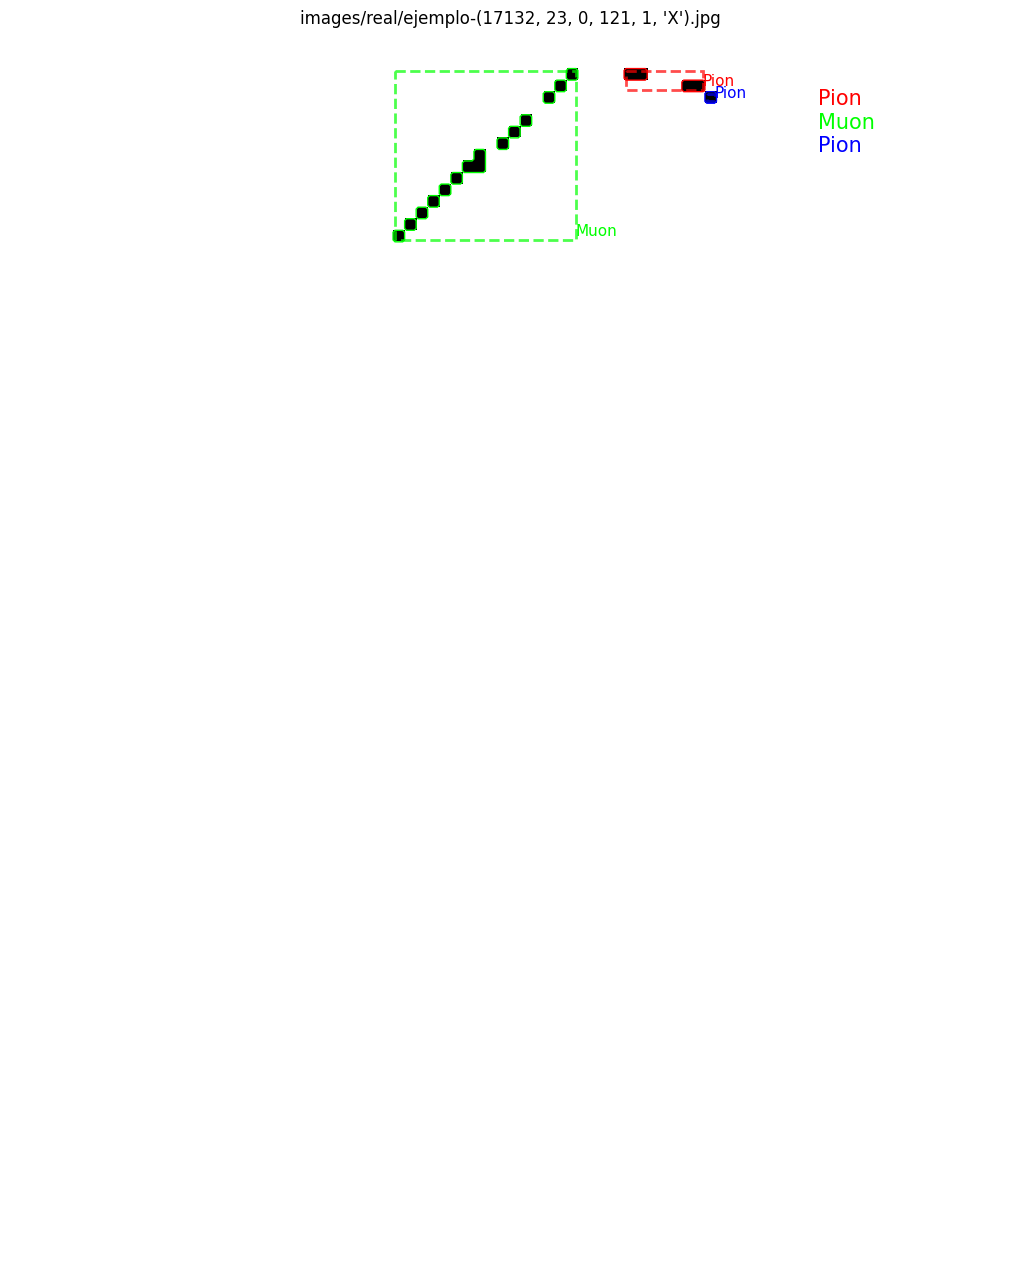

torch.Size([3, 255, 240])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[  0.,   0.,   0.],
        [255., 255., 255.]])


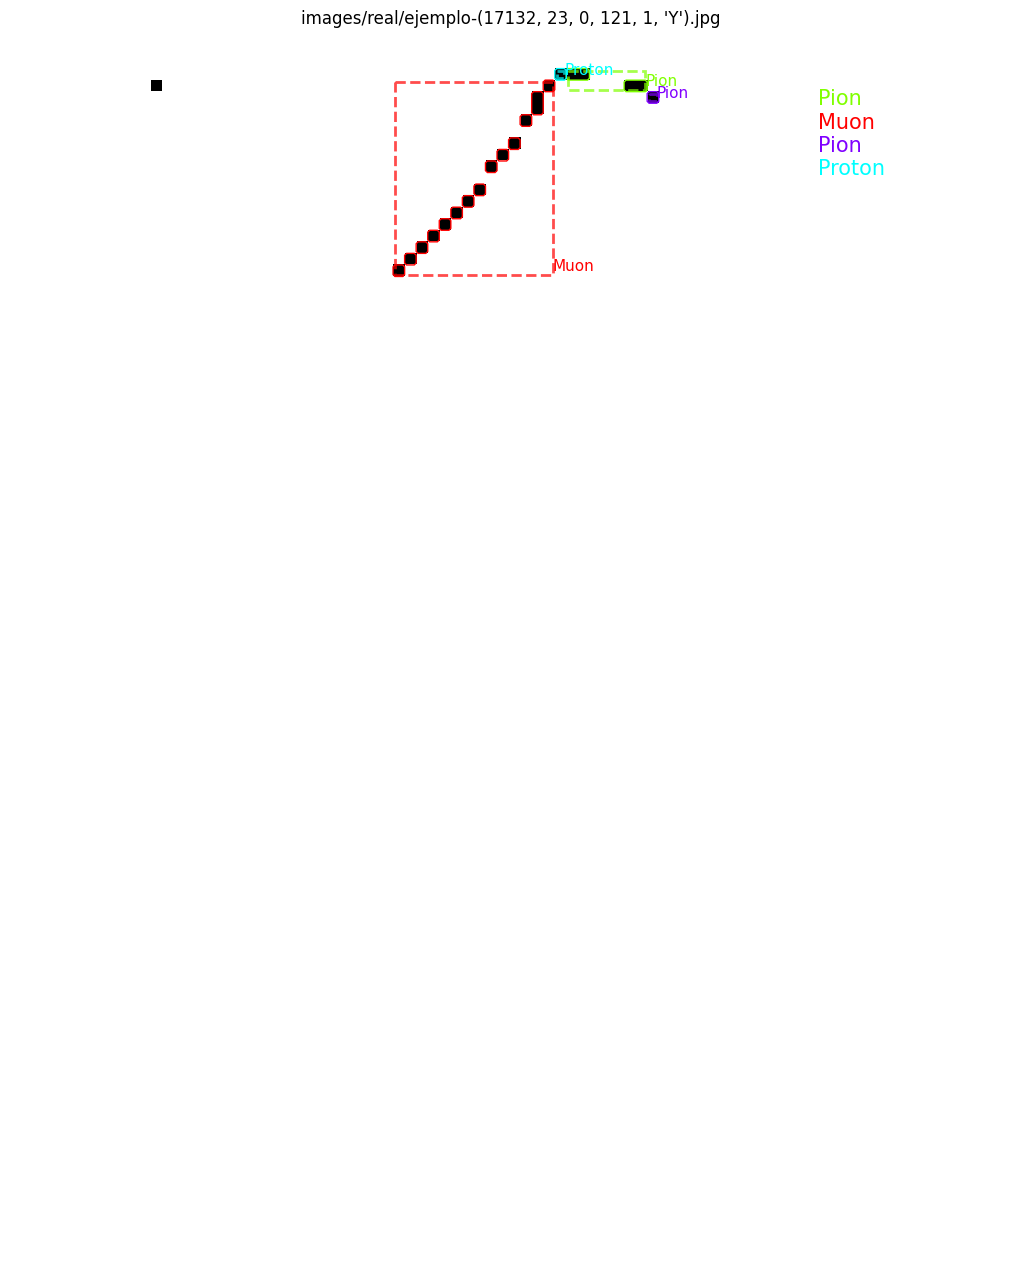

torch.Size([3, 255, 240])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[  0.,   0.,   0.],
        [255., 255., 255.]])


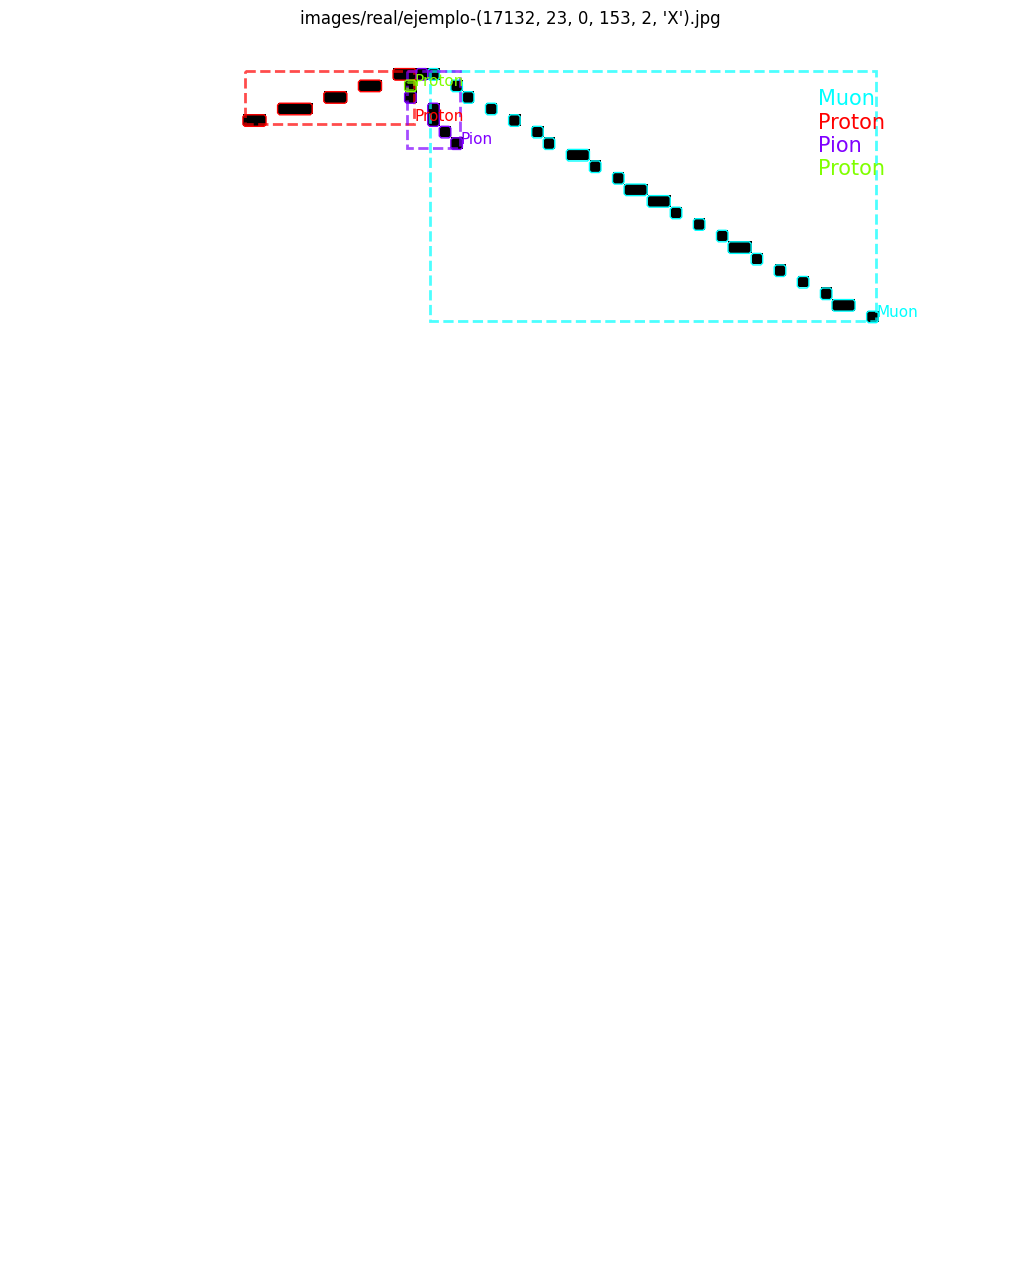

In [10]:
import matplotlib.pyplot as plt
dataset_path='/wclustre/nova/users/rafaelma2/NOvA-Clean/datos/procesados/demos_slice/'
files=os.listdir(dataset_path)
files = [dataset_path+f for f in files]
dataset=ImageSegmentationDataset(files)
for i in range(3):
    
    real=dataset[i]
    display_instances(
            real["pixel_values"], 
            generar_cuadros_delimitadores(real['mask_labels']),
            real['mask_labels'].permute(1, 2, 0), 
            real['class_labels'], 
            ['Electron', 'Muon', 'Proton', 'Photon', 'Pion'],
            title='images/real/ejemplo-'+str(real["run_info"])+'.jpg',
            save=False)
    
    

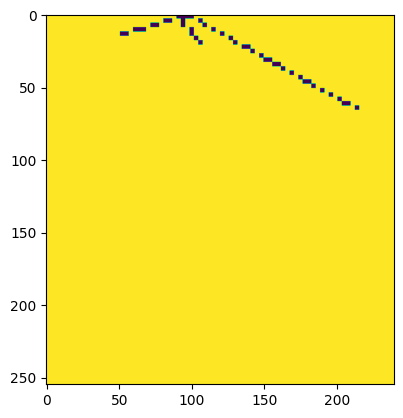

In [8]:
plt.imshow(real["pixel_values"][2])